<b>Inroduction</b><br>

The insurance company wants to perform several tasks. Each task is based in the preceding one.

- 1) Find customers who are similar to a given customer.
- 2) Predict whether a new customer is likely to receive an insurance benefit (using the technique from task 1). 
- 3) Predict the number of insurance benefits a new customer is likely to receive, using a linear regression model (and based on the KNN techinque used previously).
- 4) Protect clients' personal data without impacting the model from the previous task. For this task, we need to develop a data transformation algorithm that would make it hard to recover personal information in case the data fell into the wrong hands. This is called data obfuscation. However, this obfuscation should not impact the quality of predictions made by the ML model. We need to prove that the obfuscating algorithm works correctly.

## Data Preprocessing & Exploration
### Import Libraries

In [1]:
# general libraries
import numpy as np
import pandas as pd
import math
from IPython.display import display

# graphing librarires
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn libraries
import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

### Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [2]:
df = pd.read_csv('insurance_us.csv')

We rename the colums to make the code look more consistent with its style.

In [3]:
# rename columns
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

### Display Data

In [4]:
# display a sample of the data
df.sample(10)

,gender,age,income,family_members,insurance_benefits
4008,1,22.0,28700.0,1,0
3476,0,25.0,43400.0,0,0
899,0,36.0,34600.0,3,0
4540,0,42.0,41600.0,1,1
3903,1,24.0,48400.0,0,0
4211,0,29.0,40800.0,3,0
895,1,33.0,40300.0,2,0
216,0,32.0,42200.0,1,0
4992,0,45.0,54600.0,0,1
2616,0,31.0,40700.0,0,0


In [39]:
# display information about the dataframe and its columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   gender                       5000 non-null   int64  
 1   age                          5000 non-null   float64
 2   income                       5000 non-null   float64
 3   family_members               5000 non-null   int64  
 4   insurance_benefits           5000 non-null   int64  
 5   insurance_benefits_received  5000 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 234.5 KB


In [6]:
# the data's descriptive statistics
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


- In the insurance benefits column, the mean is 0.148, whereas the max is 5. This may indicate that the max value is an outlier.
- Also in the column of family members we see that the mean is 1.19, whereas the max is 6.
- In the income column the mean is almost 40k, the max is 79k, but the min is 5300.

### EDA

#### Features Histogram

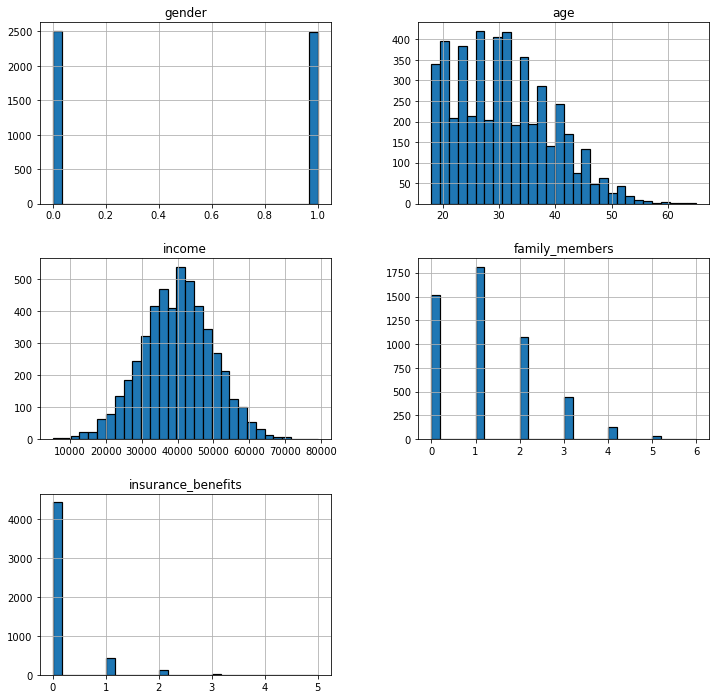

In [7]:
df.hist(bins = 30, edgecolor='black', linewidth=1.2, figsize=(12,12));

- The age column is right skewed
- The family members column is rught skewed, and the number 6 hardly exists
- Note that in the insurance_benefits column, which will be the base of our target column, there are mostly values of 0
- The income column is normally distributed
- The gender column is binary, and both values are equally distributed.

#### Insurance Benefits Distribution

In [8]:
print('The share of values in the insurance benefits columns, in precentage:\n',df['insurance_benefits'].\
      value_counts(normalize=True)*100)

The share of values in the insurance benefits columns, in precentage:
 0    88.72
1     8.46
2     2.30
3     0.36
4     0.14
5     0.02
Name: insurance_benefits, dtype: float64


- Indeed, there are 88.72% of zeros in the target.

#### Features Correlations

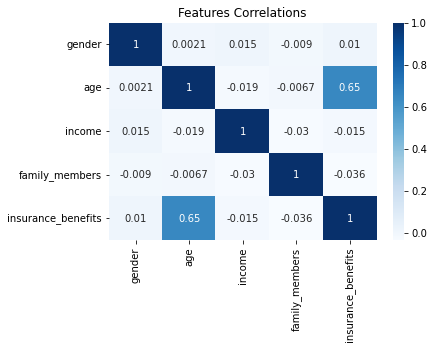

In [9]:
#checking correlations
ax = plt.axes()
sns.heatmap(df.corr(), cmap='Blues', annot=True)
ax.set_title('Features Correlations')
plt.show();

- We see a correlation between age and insurance benefits, suggesting that age impacts the benefits. This makes sense for several reasons, the main one is that older people have more things they want to ensure.

## Four Tasks
### Task 1: Find Similar Customers

In [10]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [11]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors
    df: pandas DataFrame used to find similar objects within
    n: object no for which the nearest neighbours are looked for
    k: the number of the nearest neighbours to return
    metric: name of distance metric
    """

    nbrs = NearestNeighbors(n_neighbors = k, metric=metric) 
    nbrs.fit(df.values)
    
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

#### KNN without Scaling

In [40]:
# finding values for k neighbors: without scaling
print('KNN Without Scaling\n--------------------')
print('Euclidean Distances')
display(get_knn(df[feature_names], 1500, 10, 'euclidean'))
print()
print('Manhattan Distances')
display(get_knn(df[feature_names], 1500, 10, 'manhattan'))

KNN Without Scaling
--------------------
Euclidean Distances


,gender,age,income,family_members,distance
1500,1,25.0,35600.0,2,0.000000
4734,1,27.0,35600.0,1,2.236068
179,0,27.0,35600.0,1,2.449490
4718,0,24.0,35600.0,0,2.449490
910,1,23.0,35600.0,0,2.828427
3191,0,27.0,35600.0,4,3.000000
3276,1,28.0,35600.0,3,3.162278
3953,1,22.0,35600.0,1,3.162278
949,0,28.0,35600.0,1,3.316625
829,0,21.0,35600.0,2,4.123106



Manhattan Distances


,gender,age,income,family_members,distance
1500,1,25.0,35600.0,2,0.0
4734,1,27.0,35600.0,1,3.0
4718,0,24.0,35600.0,0,4.0
910,1,23.0,35600.0,0,4.0
3276,1,28.0,35600.0,3,4.0
3953,1,22.0,35600.0,1,4.0
179,0,27.0,35600.0,1,4.0
949,0,28.0,35600.0,1,5.0
3191,0,27.0,35600.0,4,5.0
829,0,21.0,35600.0,2,5.0


- We see that the indices we get for both measures are the same, but the distances are a little different. The euclidean distance returns floats, whereas the manhattan distance returns integers, and numbers round up,

#### KNN with Scaling

In [14]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [15]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
2240,0.0,0.923077,0.353165,0.000000,4
4456,1.0,0.523077,0.567089,0.000000,0
1646,1.0,0.384615,0.625316,0.166667,0
3181,1.0,0.384615,0.656962,0.000000,0
3770,1.0,0.430769,0.886076,0.333333,0


In [42]:
# finding values for k neighbors: with scaling
print('KNN With Scaling\n-----------------')
print('Euclidean Distances')
display(get_knn(df_scaled[feature_names], 1500, 10, 'euclidean'))
print()
print('Manhattan Distances')
display(get_knn(df_scaled[feature_names], 1500, 10, 'manhattan'))

KNN With Scaling
-----------------
Euclidean Distances


,gender,age,income,family_members,distance
1500,1.0,0.384615,0.450633,0.333333,0.000000
2305,1.0,0.384615,0.456962,0.333333,0.006329
4426,1.0,0.384615,0.459494,0.333333,0.008861
610,1.0,0.384615,0.437975,0.333333,0.012658
4039,1.0,0.384615,0.463291,0.333333,0.012658
837,1.0,0.369231,0.453165,0.333333,0.015592
1272,1.0,0.369231,0.443038,0.333333,0.017157
3975,1.0,0.384615,0.469620,0.333333,0.018987
4639,1.0,0.400000,0.437975,0.333333,0.019923
3247,1.0,0.400000,0.463291,0.333333,0.019923



Manhattan Distances


,gender,age,income,family_members,distance
1500,1.0,0.384615,0.450633,0.333333,0.000000
2305,1.0,0.384615,0.456962,0.333333,0.006329
4426,1.0,0.384615,0.459494,0.333333,0.008861
4039,1.0,0.384615,0.463291,0.333333,0.012658
610,1.0,0.384615,0.437975,0.333333,0.012658
837,1.0,0.369231,0.453165,0.333333,0.017916
3975,1.0,0.384615,0.469620,0.333333,0.018987
1272,1.0,0.369231,0.443038,0.333333,0.022980
4639,1.0,0.400000,0.437975,0.333333,0.028043
3247,1.0,0.400000,0.463291,0.333333,0.028043


**How does the unscaled data affect the KNN algorithm?** 

1. We can see by the indices of the observations, that the k closest neighbors are different in the cases of scaled and unscaled data.<br>
2. In the unscaled data, for both distances we get the same observations, but their order changes. In the scaled data, the the obeservations are the same, and in both distances the order of them is similar, but the distance itself differs.<br>
3. In the unscaled data, all the k neighbors have the same income, whereas the scaled k records have several incomes.<br>
4. In the scaled data the gender is the same, whereas in the unscaled data the gender changes.<br>
5. The number of family members in the scaled data is fixed, whereas in the unscaled data it differs.

### Task 2: Is a Customer Likely to Receive Insurance Benefit?

In [18]:
df.head()

,gender,age,income,family_members,insurance_benefits
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [19]:
# calculate the target
df['insurance_benefits_received'] = df['insurance_benefits'].apply(lambda x: 1 if x > 0 else 0)

df.tail(10)

,gender,age,income,family_members,insurance_benefits,insurance_benefits_received
4990,0,22.0,56800.0,1,0,0
4991,0,21.0,38300.0,3,0,0
4992,0,45.0,54600.0,0,1,1
4993,1,32.0,36000.0,1,0,0
4994,1,26.0,51400.0,0,0,0
4995,0,28.0,35700.0,2,0,0
4996,0,34.0,52400.0,1,0,0
4997,0,20.0,33900.0,2,0,0
4998,1,22.0,32700.0,3,0,0
4999,1,28.0,40600.0,1,0,0


In [20]:
# check for the class imbalance with value_counts()
print('The shares of classes of the target (%)')
df['insurance_benefits_received'].value_counts(normalize=True)

The shares of classes of the target (%)


0    0.8872
1    0.1128
Name: insurance_benefits_received, dtype: float64

The data of the target is very imbalanced, where 88% of the values are 0 and only 12% are 1.

In [43]:
def eval_classifier(y_true, y_pred):
    '''
    The function takes the true labels and the predicted labels and prints the f1 score and the confusion matrix.
    '''
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [35]:
def rnd_model_predict(P, size, seed=42):
    '''
    The function return the output of a random model
    '''
    
    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

#### Dummy Model

In [47]:
print('Predicitons for the dummy model\n------------------------------')
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, len(df), seed=42)
    
    # call for the classifier evaluation
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

Predicitons for the dummy model
------------------------------
The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.8872 0.    ]
 [0.1128 0.    ]]

The probability: 0.11
F1: 0.12
Confusion Matrix
[[0.7914 0.0958]
 [0.0994 0.0134]]

The probability: 0.50
F1: 0.20
Confusion Matrix
[[0.456  0.4312]
 [0.053  0.0598]]

The probability: 1.00
F1: 0.20
Confusion Matrix
[[0.     0.8872]
 [0.     0.1128]]



In [24]:
# split the data into features and target
features = df.drop(['insurance_benefits','insurance_benefits_received'], axis=1)
target = df['insurance_benefits_received']

In [25]:
# split the sets into train and test sets
features_train, features_test, target_train, target_test = train_test_split\
(features, target, test_size=0.3, random_state=12345)

# print shapes
print('Train:',features_train.shape)
print('Test:',features_test.shape)

Train: (3500, 4)
Test: (1500, 4)


In [26]:
# scaling the data and keeping it in separate variables

# create a copy of both features sets
scaled_train = features_train.copy()
scaled_test = features_test.copy()

# scaling
scaled_train = sklearn.preprocessing.MaxAbsScaler().fit_transform(scaled_train.to_numpy())
scaled_test = scaling.transform(scaled_test.to_numpy())

# change into df
scaled_train = pd.DataFrame(scaled_train, columns = feature_names)
scaled_test = pd.DataFrame(scaled_test, columns=feature_names)

# display
display(scaled_train.head())
display(scaled_test.head())

,gender,age,income,family_members
0,0.0,0.446154,0.255696,0.000000
1,0.0,0.569231,0.472152,0.333333
2,0.0,0.523077,0.408861,0.333333
3,1.0,0.553846,0.579747,0.166667
4,0.0,0.600000,0.473418,0.000000


,gender,age,income,family_members
0,0.0,0.507692,0.493671,0.666667
1,0.0,0.769231,0.545570,0.333333
2,1.0,0.600000,0.532911,0.000000
3,0.0,0.307692,0.440506,0.000000
4,0.0,0.630769,0.506329,0.666667


#### KNN without Scaling

In [29]:
print('KNN: Unscaled data')
for i in range(1,11):
    model = KNeighborsClassifier(n_neighbors=i, metric= 'euclidean')
    model.fit(features_train, target_train)
    predictions = model.predict(features_test)
    print('K =',i)
    eval_classifier(target_test, predictions)
    print()

KNN: Unscaled data
K = 1
F1: 0.60
Confusion Matrix
[[0.87066667 0.02066667]
 [0.05266667 0.056     ]]

K = 2
F1: 0.41
Confusion Matrix
[[0.88733333 0.004     ]
 [0.08       0.02866667]]

K = 3
F1: 0.41
Confusion Matrix
[[0.87933333 0.012     ]
 [0.078      0.03066667]]

K = 4
F1: 0.28
Confusion Matrix
[[0.88866667 0.00266667]
 [0.09066667 0.018     ]]

K = 5
F1: 0.27
Confusion Matrix
[[0.88533333 0.006     ]
 [0.09066667 0.018     ]]

K = 6
F1: 0.11
Confusion Matrix
[[0.89       0.00133333]
 [0.102      0.00666667]]

K = 7
F1: 0.11
Confusion Matrix
[[0.88866667 0.00266667]
 [0.102      0.00666667]]

K = 8
F1: 0.07
Confusion Matrix
[[0.89133333 0.        ]
 [0.10466667 0.004     ]]

K = 9
F1: 0.08
Confusion Matrix
[[0.89133333 0.        ]
 [0.104      0.00466667]]

K = 10
F1: 0.00
Confusion Matrix
[[0.89133333 0.        ]
 [0.10866667 0.        ]]



- We see that as the k increases, the f1 score decreases.

#### KNN with Scaling

In [30]:
print('KNN: Scaled data')
for i in range(1,11):
    knn_f = KNeighborsClassifier(n_neighbors=i)
    knn_f.fit(scaled_train, target_train)
    predictions = knn_f.predict(scaled_test)
    print('K =',i)
    eval_classifier(target_test, predictions)
    print()

KNN: Scaled data
K = 1
F1: 0.97
Confusion Matrix
[[0.88866667 0.00266667]
 [0.00466667 0.104     ]]

K = 2
F1: 0.93
Confusion Matrix
[[8.90666667e-01 6.66666667e-04]
 [1.40000000e-02 9.46666667e-02]]

K = 3
F1: 0.95
Confusion Matrix
[[0.88933333 0.002     ]
 [0.00866667 0.1       ]]

K = 4
F1: 0.91
Confusion Matrix
[[0.88933333 0.002     ]
 [0.01666667 0.092     ]]

K = 5
F1: 0.92
Confusion Matrix
[[0.88666667 0.00466667]
 [0.01133333 0.09733333]]

K = 6
F1: 0.90
Confusion Matrix
[[0.89       0.00133333]
 [0.018      0.09066667]]

K = 7
F1: 0.92
Confusion Matrix
[[0.88733333 0.004     ]
 [0.01266667 0.096     ]]

K = 8
F1: 0.90
Confusion Matrix
[[0.88866667 0.00266667]
 [0.01733333 0.09133333]]

K = 9
F1: 0.92
Confusion Matrix
[[0.88866667 0.00266667]
 [0.01466667 0.094     ]]

K = 10
F1: 0.88
Confusion Matrix
[[0.88866667 0.00266667]
 [0.02133333 0.08733333]]



- In the scaled data the f1 score has no consistant pattern. Sometimes the f1 score decreasing while the k decreases, other times it increases while the k decreases, and some other times the f1 and the k both increase or decrease. Regardless of the inconsistancy in pattern, the f1 score is always high, with the lowest value being 0.88 when k=10, up until 0.97 when k=1.

### Task 3. Linear Regression

In [ ]:
class MyLinearRegression:
    '''
    This is a class of a linear regression model
    '''
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)

    def predict(self, X):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X.dot(self.weights[1:]) + self.weights[0]
        
        return y_pred

In [ ]:
def eval_regressor(y_true, y_pred):
    '''
    The fuction prints RMSE and R2 scores of a model.'''
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [ ]:
# creating the features set
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
# creating the target set
y = df['insurance_benefits'].to_numpy()

# splitting the features and target sets into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

print('Unscaled data')
lr = MyLinearRegression()

lr.fit(X_train, y_train)
display(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

In [ ]:
# scaling the features
scaling = sklearn.preprocessing.MaxAbsScaler().fit(X_train)
scaled_X_train = scaling.transform(X_train)
scaled_X_test = scaling.transform(X_test)

In [ ]:
# training with scaled data
lr = MyLinearRegression()

print('Scaled data')
lr.fit(scaled_X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(scaled_X_test)
eval_regressor(y_test, y_test_pred)

Whether the data is scaled or not, the RMSE and the R2 scores are the same. This may be due to ???

### Task 4. Obfuscating Data without Disrupting the ML Model

In [ ]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [ ]:
X = df_pn.to_numpy()
display(X)
X.shape

Generating a random matrix $P$

In [ ]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))
display(P)
display(P.shape)

Checking whether the matrix $P$ is invertible

In [ ]:
# printing the inversion matrix of P
print('The inversion matrix of P')
P_inverted = np.linalg.inv(P)
print(P_inverted)

It appears that $P$ is indeed invertible.

In [ ]:
print('Multiplying the numerical features by the random matrix P\n')
X_mult = (X.dot(P))
print(X_mult)
X_mult.shape

The age became a column with very high values, of 4 digits or more. The income, on the other hand, decreased, and now it's in the lower 4 digits numbers (perhaps not more than 20k) or lower.

Can we recover the original data from $X'$ if we know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.<br><br>
$$
X'\times(invertedP) = X
$$

In [ ]:
recovered = X_mult.dot(P_inverted)
print("Recovering the original X' by multiplying X by the inversion of P")
recovered

In [ ]:
print('The original data')
display(X[50:56])
print()
print('The transformed data')
display(X_mult[50:56])
print()
print('The reveresed (recovered) data')
display(recovered[50:56])

Some values are not exactly the same as they are in the original data. The only changes are from 0.00e+00 in the original data, to 3.63797881e-12 in the recovered data, in three places. Both number are very small and very close to zero. All the values in both data sets are around 0 and 1. After converting the original dataframe to numpy, these are the values that we got.

#### Logical Proof That Data Obfuscation Can Work with LinearRegression

Following is an analytical proof that the given obfuscation method will not affect the predictions of the linear regression model we have in hand.

The data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as<br><br>
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$
<br>Dealing with the right side: transposition:<br>
$$
w_P = [P^TX^T XP]^{-1} P^TX^T y
$$
<br>Inversion:<br>
$$
w_P = (P)^{-1}(X^TX)^{-1} (P^T)^{-1} P^T X^T y
$$
<br>Identity:<br>
$$
w_P = (P)^{-1}(X^TX)^{-1} I X^T y
$$
<br>Removing the $I$ due to its redundancy:<br>
$$
w_P = (P)^{-1}(X^TX)^{-1} X^T y
$$
<br>Replacing the part equal to $w$ in the $w_P$ formula:<br>
$$
w_P = (P)^{-1} w
$$
<br><b>How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above?</b> <br>
The two formulas are similar, and the only difference between them is that $w_P$ includes the inverted P ($(P)^{-1}$).<br><br>

<b>What would be predicted values with $w_P$? </b><br>
We begin with the following formula:
$$
\hat{y_p} = XPw_p
$$
<br>Replacing $w_P$ with $(P)^{-1}w$:<br>
$$
\hat{y_p} = XP (P)^{-1} w
$$
<br>Identity:<br>
$$
\hat{y_p} = X I w
$$
<br>Removing the $I$ due to its redundancy:
$$
\hat{y_p} = X w
$$
<br>Which is equal to:<br>
$$
y = X w
$$

This means that to get the prediction (${y_p}$), we apply the weight $w$ to the original $X$. The P matrix does not change the predictions.

<b>What does that mean for the quality of linear regression if you measure it with RMSE?</b><br>
It does not impact the RMSE, since the RMSE takes the target and the predictions array, and we saw that the predictions don't change and the target was not touched.<br><br>

#### Test Linear Regression With Data Obfuscation

<b>Create a square matrix $P$ of random numbers</b>

In [ ]:
rng = np.random.default_rng(seed=121)
P2 = rng.random(size=(X.shape[1], X.shape[1]))
display(P2)
display(P2.shape)

<b>Check that it is invertible</b>

In [ ]:
# is P invertible?
P2_inverted = np.linalg.inv(P2)

print(P2_inverted)

The new P2 matrix is invertible.<br><br>
<b>Use the class we created prevously</b>

In [ ]:
# create new features XP
print('The new features XP data set')
XP = pd.DataFrame(X.dot(P))
XP.columns =['age', 'gender', 'income', 'family_members']
XP.head()

In [ ]:
XP = XP[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(XP, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

<b>Compare to the original results we got in step 3</b>

In [ ]:
# original results from step 3
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
display(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

# Conclusions<a class="anchor" id="6"></a>

<b>Task 1</b><br>
Finding customers who are similar to a given customer.

- We saw the differences between the two distance metrics (euclidean and manhattan), and between the scaled and unscaled data.<br>
- We saw that for scaled vs. unscaled data, the similarity was in a different feature (in the scaled: gender, family members; in the unscaled: income).

<b>Task 2</b><br>
Checking how likely is a new customer to receive an insurance benefit, and can a prediction model do better than a dummy model.<br>
- Comparing the f1 scores, the dummy model gave the best score 0f 0.2, whereas the prediction model had a score of 0.6 (for unscaled data) and 0.97 (for scaled data).<br>
- We saw that in the KNN model, the bigger k is the lower the f1 sore is.

<b>Task 3</b><br>
Checking how many insurance benefits is a new customer likely to receive (using a linear regression model).<br>
- We saw that the scaled and unscaled data both got the same sf1 scores in the LR model.

<b>Task 4</b><br>
Data Obfuscation.
- We checked whether obfuscation is reversible, and we discovered that it is. When we recovered the original data from the obfuscated data, we got the same results.<br>
- We checked whether the obfustcation impacts the predictions of the LR model, and we discovered that RMSE and R2 scores for both sets of data were the same.<br>

#### Appendix: Properties of Matrices
Matrices have many properties in Linear Algebra. A few of them are listed here which can help with the analytical proof in this project.<br>

<table>
<tr>
<td>Distributivity</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Multiplicative identity property</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversivity of the transpose of a product of matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>